In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import guitarpro

import matplotlib.pyplot as plt

from src.markov_chain import MarkovChain
from src.parse_gp import drop_rests_from_drum_track, get_notes_and_durations
from src.save_midi import save_notes_and_durations, save_notes

In [2]:
folderpath = "tabs/"
use_durations = True

In [3]:
notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        tab_notes, tab_durations = get_notes_and_durations(tab, None, False)
        notes += tab_notes
        durations += tab_durations

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
note_dictionary = {note: i for i, note in enumerate(set(notes))}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes]
notes_to_int[:10]

[97, 41, 25, 0, 25, 121, 0, 25, 25, 0]

In [5]:
notes[:10]

['del', '46.36.', '42.', '', '42.', '51.40.', '', '42.', '42.', '']

In [6]:
duration_dictionary = {dur: i for i, dur in enumerate(set(durations))}
inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
durations_to_int = [duration_dictionary[dur] for dur in durations]
durations_to_int[:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [7]:
durations[:10]

[1, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625]

In [8]:
markov_notes = MarkovChain()
markov_notes.fit_partial(notes_to_int)

In [9]:
markov_durations = MarkovChain()
markov_durations.fit_partial(durations_to_int)

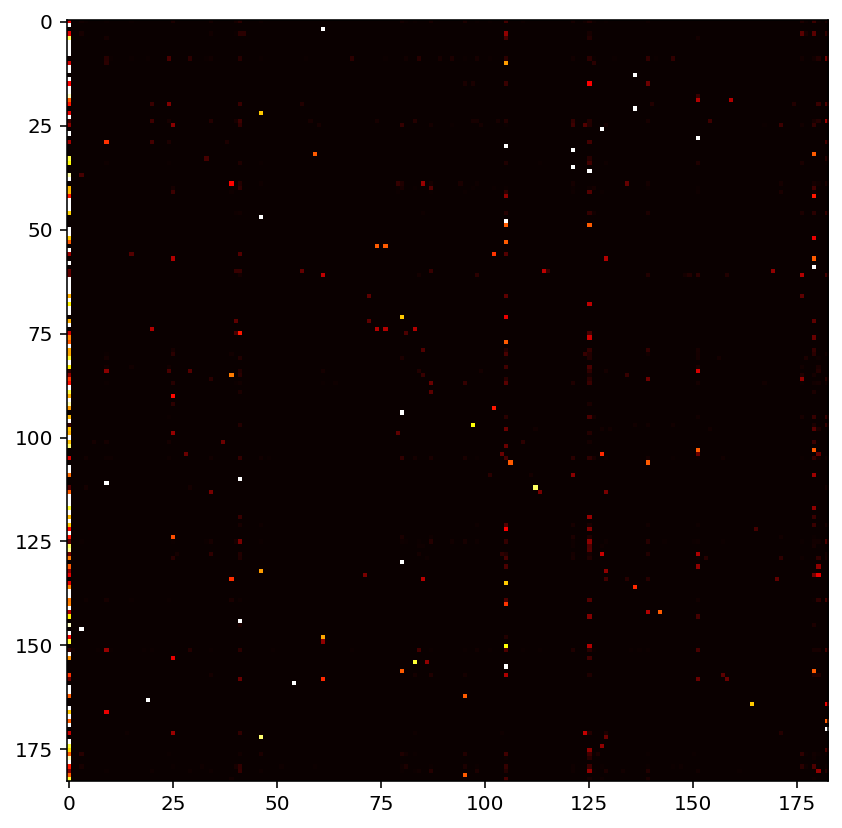

In [10]:
note_matrix = markov_notes.heatmap_of_transitions()

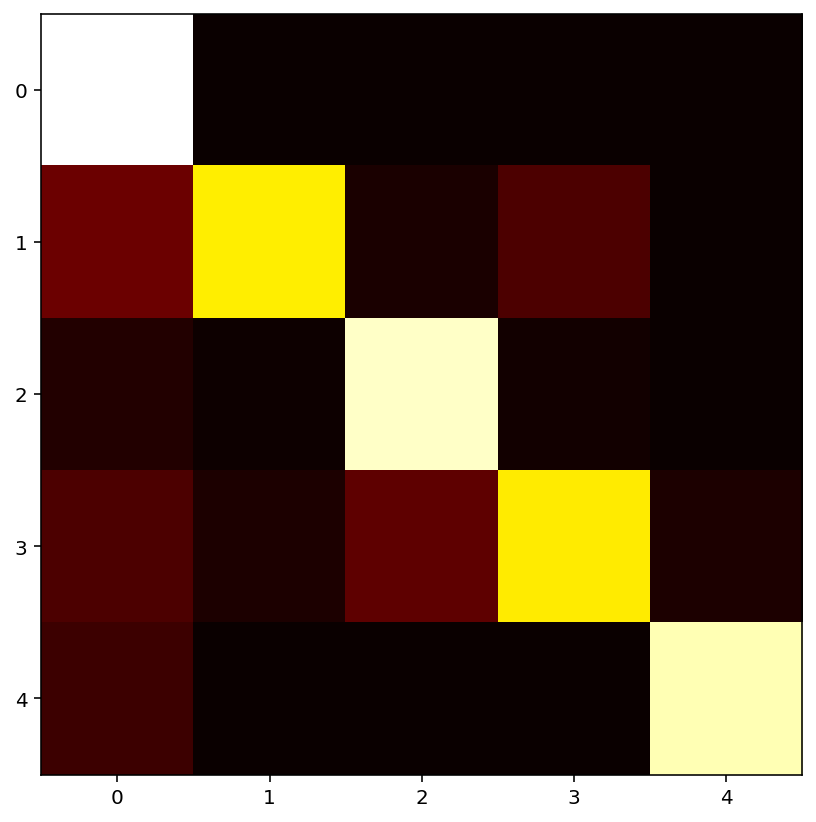

In [11]:
duration_matrix = markov_durations.heatmap_of_transitions()

In [12]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [13]:
temperature = 0.9
generated_notes = [note_dictionary['46.36.']]
generated_durations = [duration_dictionary[1/16]]
for i in range(100):
    probas = [markov_notes.predict_proba_state_transition(generated_notes[i], note_dictionary[x]) + 1e-6 for x in note_dictionary]
    generated_notes.append(sample(probas, temperature))
    
    probas = [markov_durations.predict_proba_state_transition(generated_durations[i], duration_dictionary[x]) + 1e-6 for x in duration_dictionary]
    generated_durations.append(sample(probas, temperature))

In [14]:
generated_notes[:10]

[41, 0, 80, 0, 124, 0, 0, 0, 95, 0]

In [15]:
generated = [[inv_note_dictionary[x] for x in generated_notes], [inv_dur_dictionary[x] for x in generated_durations]]

In [16]:
save_notes_and_durations(generated, 'markov_output')

In [17]:
save_notes([inv_note_dictionary[x] for x in generated_notes], 'markov_output_only_notes')